# Real Estate Image Classification

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.image as img
import cv2
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten,Input,Activation,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from skimage import exposure
from PIL import Image
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.python.keras import optimizers
import keras

In [ ]:
# Function to return Dataframe having images path, class label and type.
def file_dir_df(root):
  '''
  this function will return dataframe which contain path, label and type of images
  '''
  path = []
  label = []
  type = []
  for r, d, f in os.walk(root):
    for file in f:
      if r is not root:
        path.append(r+"/"+file)
        label.append(r.split('/')[1])
        type.append(file.split('.')[1])

  return pd.DataFrame({'path':path,"label":label,"type":type})

In [ ]:
df = file_dir_df('dataset')

In [ ]:
'''
# saving dataframe for later use
with open("drive/MyDrive/Self Case study/Real estate image/dataframe","wb") as loc:
  pickle.dump(df, loc)
'''

In [ ]:
# saving dataframe for later use
with open("drive/MyDrive/Self Case study/Real estate image/dataframe","rb") as loc:
  df = pickle.load( loc)

In [ ]:
df.head()

,path,label,type
0,dataset/backyard/backyard (534).jpg,backyard,jpg
1,dataset/backyard/backyard (229).jpg,backyard,jpg
2,dataset/backyard/backyard (72).jpg,backyard,jpg
3,dataset/backyard/backyard (503).jpg,backyard,jpg
4,dataset/backyard/backyard (555).jpg,backyard,jpg


## Preprocessing

In [ ]:
with open("drive/MyDrive/Self Case study/Real estate image/dataframe","rb") as loc:
  preprocessed_df = pickle.load(loc)

In [ ]:
#Lebel encoding Classes
vec = CountVectorizer()
vec.fit_transform(preprocessed_df['label'])
vocab_dic = vec.vocabulary_
labels = dict((v,k) for k,v in vocab_dic.items())

In [ ]:
'''
# saving preprocessed data for later use
with open("drive/MyDrive/Self Case study/Real estate image/preprocessed_data","wb") as loc:
  pickle.dump((X_train, X_test), loc)
'''

In [3]:
with open("drive/MyDrive/Self Case study/Real estate image/preprocessed_data","rb") as loc:
  X_train, X_test, = pickle.load(loc)

In [4]:
def plot_confusion_matrix(test_y, predict_y):
  
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
   
    labels = vocab_dict.keys()
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [5]:
#Image Augmentation
datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5),
        )

datagen_test = ImageDataGenerator(rescale=1./255)


train_generator=datagen_train.flow_from_dataframe(
    X_train, x_col='path', 
    y_col='label',
    class_mode="categorical",
    target_size=(224,224), 
    batch_size=32)

test_generator=datagen_test.flow_from_dataframe(
    X_test, x_col='path', 
    y_col='label',
    class_mode="categorical",
    target_size=(224,224), 
    batch_size=32)


Found 4687 validated image filenames belonging to 6 classes.
Found 1172 validated image filenames belonging to 6 classes.


## Bseline Model

In [ ]:
# Baseline Model
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_50 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 222, 222, 32)      18464     
                                                                 
 activation_51 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 111, 111, 32)      0         
                                                     

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/baseline_weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=test_generator,
          validation_steps=STEP_SIZE_TEST,
          callbacks = callbacks,
          epochs = 20)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
146/146 [==============================] - 97s 644ms/step - loss: 1.7932 - accuracy: 0.2526 - val_loss: 1.7713 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 98s 672ms/step - loss: 1.7139 - accuracy: 0.2973 - val_loss: 1.5293 - val_accuracy: 0.3880 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 94s 643ms/step - loss: 1.6325 - accuracy: 0.3027 - val_loss: 1.3481 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 94s 645ms/step - loss: 1.5037 - accuracy: 0.3244 - val_loss: 1.2722 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 94s 643ms/step - loss: 1.4006 - accuracy: 0.3691 - val_loss: 1.2138 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 102s 701ms/step - loss: 1.3329 - accuracy: 0.3970 - val_loss: 1.21

In [ ]:
# resume traning from previous last epoch 
model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=test_generator,
          validation_steps=STEP_SIZE_TEST,
          callbacks = callbacks,
          epochs = 20)

Epoch 1/20
146/146 [==============================] - 98s 668ms/step - loss: 1.0876 - accuracy: 0.4806 - val_loss: 0.8996 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 96s 659ms/step - loss: 1.0581 - accuracy: 0.5081 - val_loss: 0.9037 - val_accuracy: 0.6007 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 100s 684ms/step - loss: 1.0602 - accuracy: 0.5063 - val_loss: 0.8827 - val_accuracy: 0.5842 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 95s 652ms/step - loss: 1.0625 - accuracy: 0.5066 - val_loss: 0.9035 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 99s 680ms/step - loss: 1.0522 - accuracy: 0.5085 - val_loss: 0.8901 - val_accuracy: 0.5946 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 100s 685ms/step - loss: 1.0286 - accuracy: 0.5126 - val_loss: 0.8808 - val_accuracy: 0.5851 - lr: 0.0010
Epoch 7/20
146/146 [==============================

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/baseline", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/baseline", "r") as json_file:
    baseline_model = json_file.read()
baseline_model = model_from_json(baseline_model)
baseline_model.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/baseline_weights.h5')
baseline_model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
baseline_model.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.8065910935401917, 0.6493173837661743]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  35.06825938566553
-------------------------------------------------- Confusion matrix --------------------------------------------------


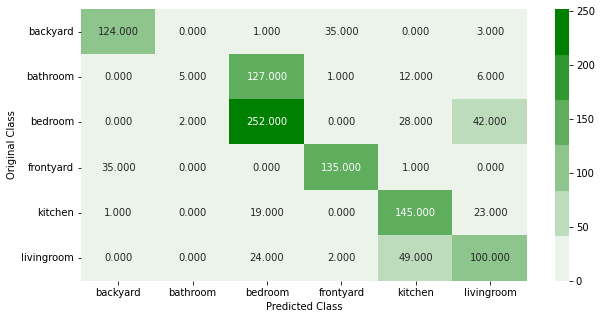

-------------------------------------------------- Precision matrix --------------------------------------------------


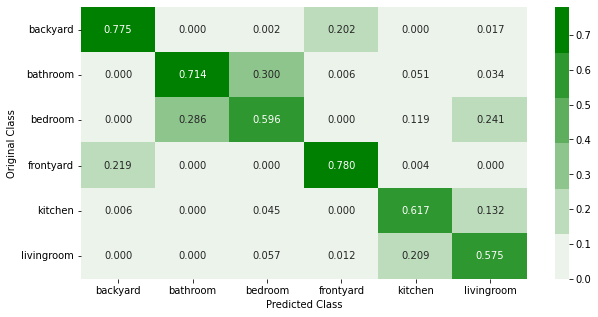

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


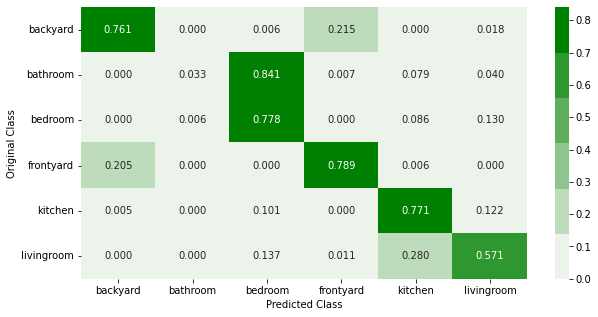

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(baseline_model.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

## Transfer **Learning**

### VGG16 

In [ ]:
!rm -rf ./logs/ 

vgg16_layer = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

conv_layer = Conv2D(32,kernel_size=(3,3),activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(vgg16_layer.output)
pool = MaxPooling2D(pool_size=(2,2))(conv_layer)

faltten_layer = Flatten()(pool)
fc1 = Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(faltten_layer)
fc2 = Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(fc1)

output_layer = Dense(6,activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(fc2)

for layer in vgg16_layer.layers:
  layer.trainable = False

VGG_1 = Model(vgg16_layer.input,output_layer)
VGG_1.compile(optimizer='adam',loss='CategoricalCrossentropy', metrics=['accuracy'])
VGG_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg16_1.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

VGG_1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 89s 579ms/step - loss: 1.9231 - accuracy: 0.6217 - val_loss: 1.1946 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 81s 552ms/step - loss: 1.1012 - accuracy: 0.7933 - val_loss: 0.9470 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 85s 585ms/step - loss: 0.8753 - accuracy: 0.8230 - val_loss: 0.7553 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 86s 586ms/step - loss: 0.7857 - accuracy: 0.8369 - val_loss: 0.6784 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 85s 585ms/step - loss: 0.6811 - accuracy: 0.8561 - val_loss: 0.6302 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 86s 588ms/step - loss: 0.6383 - accuracy: 0.8586 - val_loss: 0.5776 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 7/20
146/146 [==============================] 

In [ ]:
# serialize model to JSON
model_json = VGG_1.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg_1", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg_1", "r") as json_file:
    vgg1_model = json_file.read()
vgg1_model = model_from_json(vgg1_model)
vgg1_model.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg16_1.h5')
vgg1_model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
vgg1_model.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.4092469811439514, 0.9027303457260132]

Number of misclassified points  9.726962457337883
-------------------------------------------------- Confusion matrix --------------------------------------------------


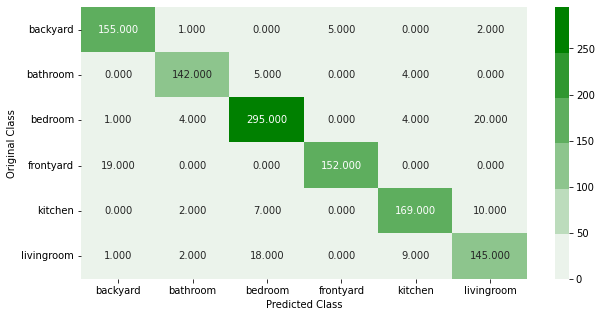

-------------------------------------------------- Precision matrix --------------------------------------------------


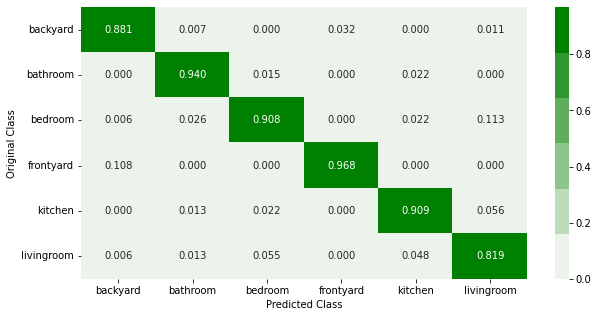

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


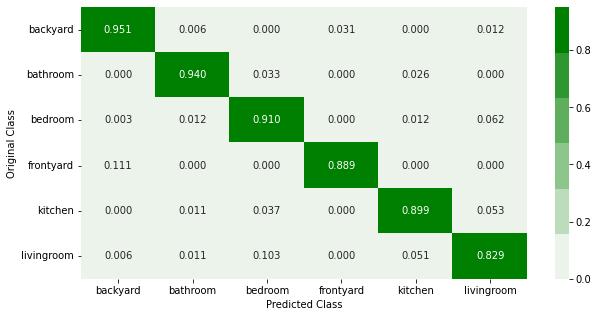

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(vgg1_model.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

### VGG16 Fine-Tune

In [ ]:
!rm -rf ./logs/ 

vgg16_layer = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

conv_layer1 = Conv2D(32,kernel_size=(7,7),activation='relu')(vgg16_layer.output)
conv_layer2 = Conv2D(32,kernel_size=(1,1),activation='relu')(conv_layer1)

faltten_layer = Flatten()(conv_layer2)
output_layer = Dense(6,activation='softmax',kernel_regularizer='l2')(faltten_layer)

for layer in vgg16_layer.layers[:len(vgg16_layer.layers)-5]:
  layer.trainable = False

VGG_2 = Model(vgg16_layer.input,output_layer)
VGG_2.compile(optimizer='adam',loss='CategoricalCrossentropy', metrics=['accuracy'])
VGG_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg16_2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

VGG_2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 90s 612ms/step - loss: 1.4078 - accuracy: 0.4511 - val_loss: 0.8005 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 83s 566ms/step - loss: 0.7147 - accuracy: 0.7454 - val_loss: 0.4332 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 82s 563ms/step - loss: 0.5553 - accuracy: 0.8079 - val_loss: 0.4879 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 83s 570ms/step - loss: 0.4517 - accuracy: 0.8505 - val_loss: 0.4002 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 87s 596ms/step - loss: 0.3861 - accuracy: 0.8793 - val_loss: 0.3539 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 83s 565ms/step - loss: 0.3486 - accuracy: 0.8894 - val_loss: 0.3494 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 7/20
146/146 [==============================] 

In [ ]:
# serialize model to JSON
model_json = VGG_2.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg_2", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg_2", "r") as json_file:
    vgg1_model = json_file.read()
vgg2_model = model_from_json(vgg1_model)
vgg2_model.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/vgg16_2.h5')
vgg2_model.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
vgg2_model.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.1941412389278412, 0.9368600845336914]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  6.313993174061433
-------------------------------------------------- Confusion matrix --------------------------------------------------


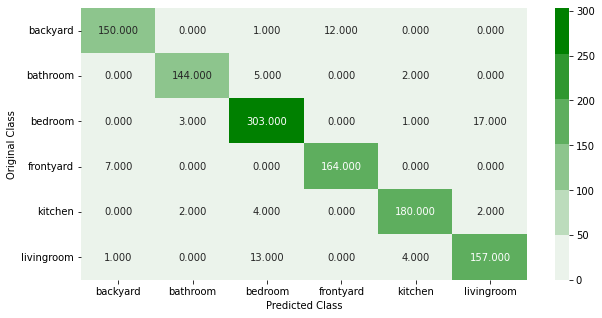

-------------------------------------------------- Precision matrix --------------------------------------------------


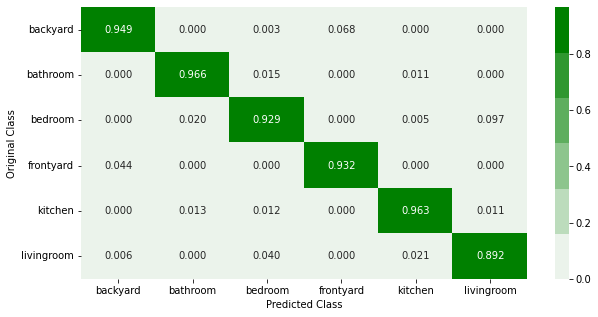

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


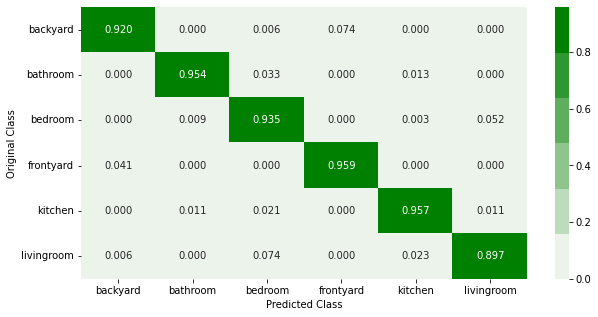

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(vgg2_model.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

### ResNet50V2

In [ ]:
!rm -rf ./logs/ 

resnet_layer = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

faltten_layer = Flatten()(resnet_layer.output)
fc1 = Dense(256,activation='relu')(faltten_layer)

output_layer = Dense(6,activation='softmax')(fc1)

for layer in resnet_layer.layers:
  layer.trainable = False

resnet_1 = Model(resnet_layer.input,output_layer)
resnet_1.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
resnet_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_1a.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

resnet_1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 129s 792ms/step - loss: 1.7963 - accuracy: 0.7828 - val_loss: 0.3387 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 113s 773ms/step - loss: 0.3436 - accuracy: 0.8752 - val_loss: 0.2817 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 110s 752ms/step - loss: 0.2843 - accuracy: 0.8917 - val_loss: 0.2723 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 108s 742ms/step - loss: 0.2674 - accuracy: 0.9014 - val_loss: 0.2873 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 109s 745ms/step - loss: 0.2255 - accuracy: 0.9212 - val_loss: 0.2720 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 111s 763ms/step - loss: 0.2117 - accuracy: 0.9240 - val_loss: 0.2464 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 7/20
146/146 [==========================

In [ ]:
# serialize model to JSON
model_json = resnet_1.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_1", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_1", "r") as json_file:
    resnet_1 = json_file.read()
resnet_1 = model_from_json(resnet_1)
resnet_1.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_1a.h5')
resnet_1.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
resnet_1.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.2407492697238922, 0.9249146580696106]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  7.508532423208192
-------------------------------------------------- Confusion matrix --------------------------------------------------


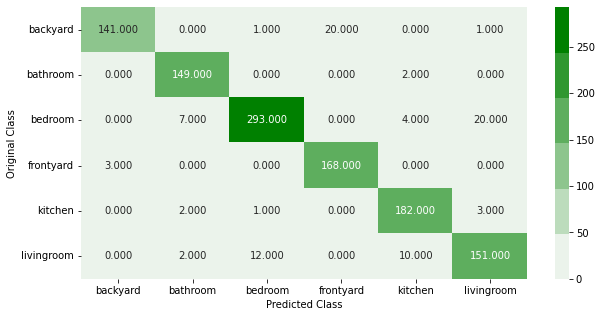

-------------------------------------------------- Precision matrix --------------------------------------------------


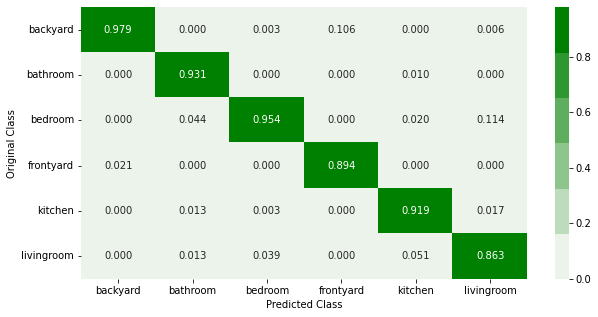

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


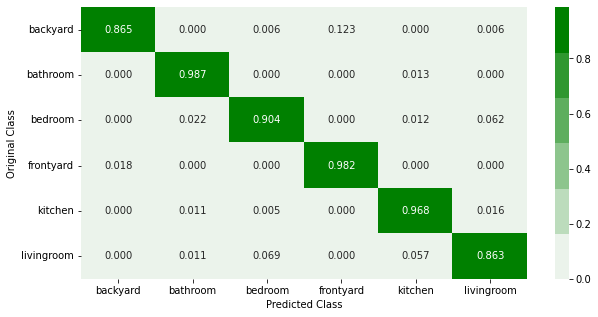

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(resnet_1.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

### ResNet50V2 Fine-Tune

In [ ]:
!rm -rf ./logs/ 

resnet_layer = resnet_layer = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

conv_layer = Conv2D(64,kernel_size=(7,7),activation='relu')(resnet_layer.output)
conv_layer2 = Conv2D(32,kernel_size=(1,1),activation='relu')(conv_layer)

faltten_layer = Flatten()(conv_layer2)
fc1 = Dense(128,activation='relu')(faltten_layer)
fc2 = Dense(64,activation='relu')(fc1)

output_layer = Dense(6,activation='softmax')(fc2)

for layer in resnet_layer.layers[:143]:
  layer.trainable = False

resnet_2 = Model(resnet_layer.input,output_layer)
resnet_2.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
resnet_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2a.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

resnet_2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 138s 872ms/step - loss: 0.6321 - accuracy: 0.7863 - val_loss: 341.4722 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 118s 808ms/step - loss: 0.4705 - accuracy: 0.8653 - val_loss: 8.4143 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 114s 781ms/step - loss: 0.5065 - accuracy: 0.8754 - val_loss: 1.3369 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 112s 768ms/step - loss: 0.3485 - accuracy: 0.8999 - val_loss: 0.7402 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 116s 796ms/step - loss: 0.2546 - accuracy: 0.9190 - val_loss: 0.2485 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 116s 796ms/step - loss: 0.1995 - accuracy: 0.9358 - val_loss: 0.1911 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 7/20
146/146 [========================

In [ ]:
# serialize model to JSON
model_json = resnet_2.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2", "w") as json_file:
    json_file.write(model_json)

In [ ]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2", "r") as json_file:
    resnet_2 = json_file.read()
resnet_2 = model_from_json(resnet_2)
resnet_2.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/resnet_2a.h5')
resnet_2.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
resnet_2.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.19878146052360535, 0.9513651728630066]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  4.863481228668942
-------------------------------------------------- Confusion matrix --------------------------------------------------


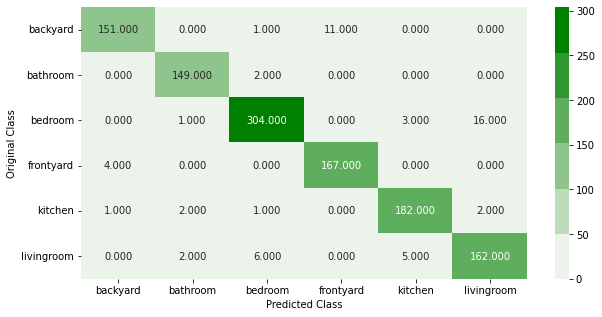

-------------------------------------------------- Precision matrix --------------------------------------------------


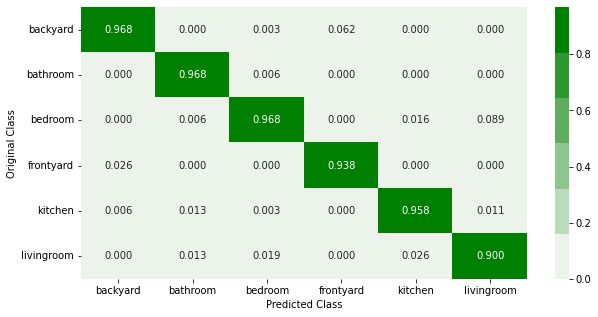

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


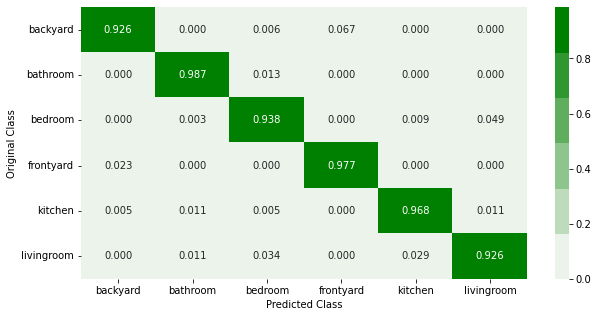

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [ ]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(resnet_2.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

### InceptionV3

In [6]:
!rm -rf ./logs/ 

inception_layer = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    classes=6,
    classifier_activation="softmax",
)

faltten_layer = Flatten()(inception_layer.output)
fc1 = Dense(256,activation='relu')(faltten_layer)
drop = Dropout(0.2)(fc1)
output_layer = Dense(6,activation='softmax')(drop)

for layer in inception_layer.layers:
  layer.trainable = False

inception_1 = Model(inception_layer.input,output_layer)
inception_1.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
inception_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_1.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

inception_1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 107s 634ms/step - loss: 3.1736 - accuracy: 0.6967 - val_loss: 0.3760 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 85s 580ms/step - loss: 0.5307 - accuracy: 0.7953 - val_loss: 0.3838 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 92s 630ms/step - loss: 0.5661 - accuracy: 0.7863 - val_loss: 0.3619 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 84s 576ms/step - loss: 0.4992 - accuracy: 0.8015 - val_loss: 0.3312 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 86s 587ms/step - loss: 0.4467 - accuracy: 0.8245 - val_loss: 0.3351 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 89s 610ms/step - loss: 0.4144 - accuracy: 0.8436 - val_loss: 0.3086 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 7/20
146/146 [==============================]

In [9]:
# serialize model to JSON
model_json = inception_1.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_1", "w") as json_file:
    json_file.write(model_json)

In [11]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_1", "r") as json_file:
    inception_1 = json_file.read()
inception_1 = model_from_json(inception_1)
inception_1.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_1.h5')
inception_1.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [12]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
inception_1.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.26933860778808594, 0.9129692912101746]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  8.70307167235495
-------------------------------------------------- Confusion matrix --------------------------------------------------


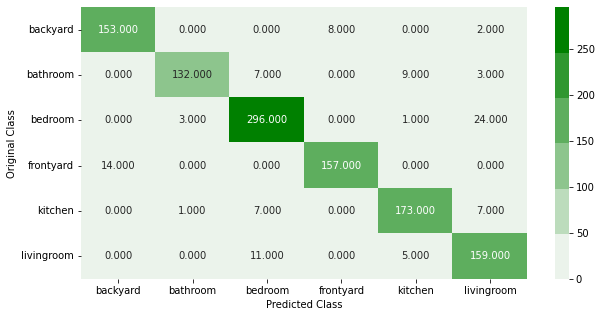

-------------------------------------------------- Precision matrix --------------------------------------------------


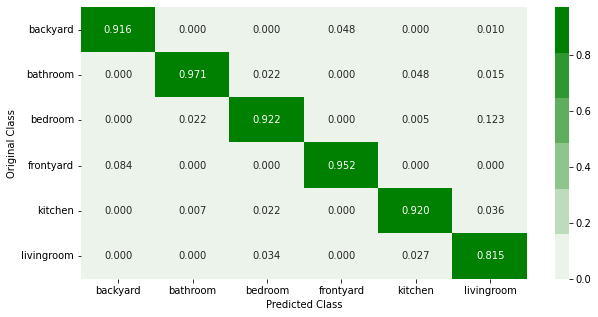

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


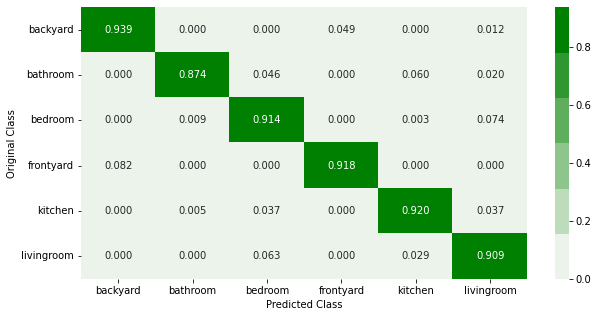

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [13]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(inception_1.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)

### IncepitionV3 Fine-Tune

In [22]:
!rm -rf ./logs/ 

inception_layer = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    classes=6,
    classifier_activation="softmax",
)

faltten_layer = Flatten()(inception_layer.output)
fc1 = Dense(256,activation='relu')(faltten_layer)
drop = Dropout(0.2)(fc1)
output_layer = Dense(6,activation='softmax')(drop)

for layer in inception_layer.layers[:249]:
  layer.trainable = False

inception_2 = Model(inception_layer.input,output_layer)
inception_2.compile(optimizer= "Adam",loss='CategoricalCrossentropy', metrics=['accuracy'])
inception_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_564 (Batch  (None, 111, 111, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                           

In [23]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

import datetime
%load_ext tensorboard
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_accuracy'),
            tf.keras.callbacks.ReduceLROnPlateau(), tensorboard_callback]

inception_2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    callbacks=callbacks,
                    epochs=20)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
146/146 [==============================] - 105s 664ms/step - loss: 1.4396 - accuracy: 0.7654 - val_loss: 0.3009 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - 94s 646ms/step - loss: 0.3171 - accuracy: 0.8943 - val_loss: 0.2598 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - 88s 602ms/step - loss: 0.2530 - accuracy: 0.9124 - val_loss: 0.2095 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - 84s 573ms/step - loss: 0.2088 - accuracy: 0.9310 - val_loss: 0.3408 - val_accuracy: 0.8915 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - 89s 607ms/step - loss: 0.1901 - accuracy: 0.9328 - val_loss: 0.2221 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - 87s 595ms/step - loss: 0.1678 - accuracy: 0.9446 - val_loss: 0.2466 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 7/20
146/146 [==============================]

In [25]:
# serialize model to JSON
model_json = inception_2.to_json()
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_2", "w") as json_file:
    json_file.write(model_json)

In [26]:
with open("/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_2", "r") as json_file:
    inception_2 = json_file.read()
inception_2 = model_from_json(inception_2)
inception_2.load_weights('/content/drive/MyDrive/Self Case study/Real estate image/Saved models/inception_2.h5')
inception_2.compile(optimizer= 'adam' ,loss="categorical_crossentropy",metrics=["accuracy"])

In [27]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
inception_2.evaluate_generator(generator=test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.1895025670528412, 0.9419795274734497]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Number of misclassified points  5.802047781569966
-------------------------------------------------- Confusion matrix --------------------------------------------------


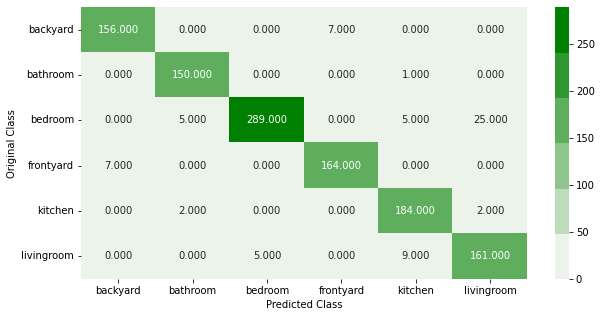

-------------------------------------------------- Precision matrix --------------------------------------------------


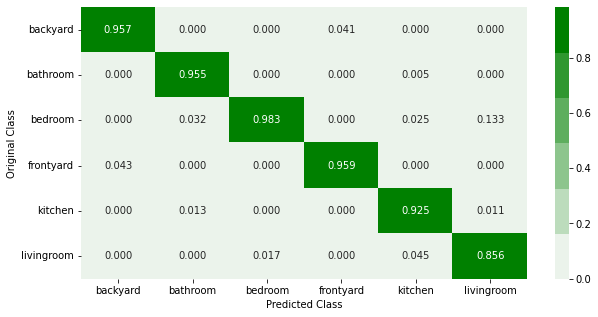

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


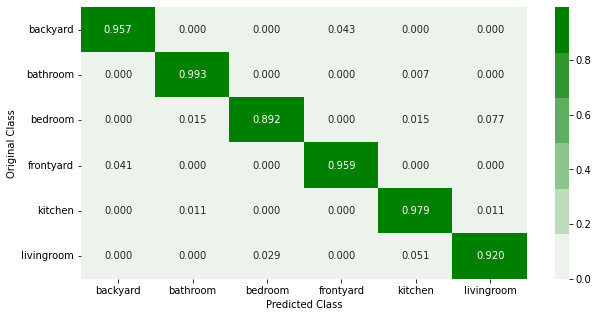

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1.]


In [28]:
n_batches = len(test_generator)
y_true = np.concatenate([np.argmax(test_generator[i][1], axis=1) for i in range(n_batches)])
predict  = np.argmax(inception_2.predict_generator(test_generator, steps=n_batches), axis=1)

vocab_dict = (train_generator.class_indices)
plot_confusion_matrix(y_true, predict)